<a href="https://colab.research.google.com/github/Fahad-H36/Mask-Detection-Using-CNNs/blob/main/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!kaggle datasets download -d mloey1/medical-face-mask-detection-dataset

In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files

In [ ]:
files.upload()



Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"fahadh36","key":"efc8d34fed0c79abace65a58c8f64649"}'}

In [ ]:
 ! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
! cp kaggle.json ~/.kaggle/



In [ ]:
 ! chmod 777 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d mloey1/medical-face-mask-detection-dataset

In [ ]:
!unzip '/content/medical-face-mask-detection-dataset.zip'

In [ ]:
!kaggle datasets download -d omkargurav/face-mask-dataset

 96% 157M/163M [00:01<00:00, 137MB/s]
100% 163M/163M [00:01<00:00, 125MB/s]


In [ ]:
!unzip '/content/face-mask-dataset.zip'

In [ ]:
!cp -r "/content/data" "/content/drive/MyDrive/MlTask"

In [ ]:
import os

In [ ]:
os.makedirs("/content/drive/MyDrive/MlTask/data/train", exist_ok=True)
os.makedirs("/content/drive/MyDrive/MlTask/data/test", exist_ok=True)




In [ ]:
os.makedirs("/content/drive/MyDrive/MlTask/data/train/withMask", exist_ok=True)
os.makedirs("/content/drive/MyDrive/MlTask/data/train/withoutMask", exist_ok=True)
os.makedirs("/content/drive/MyDrive/MlTask/data/test/withMask", exist_ok=True)
os.makedirs("/content/drive/MyDrive/MlTask/data/test/withoutMask", exist_ok=True)

In [ ]:
import shutil

maskSource = '/content/drive/MyDrive/MlTask/data/with_mask'
noMaskSource = '/content/drive/MyDrive/MlTask/data/without_mask'

maskTestDir = '/content/drive/MyDrive/MlTask/data/test/withMask'
noMaskTestDir = '/content/drive/MyDrive/MlTask/data/test/withoutMask'

a = len(os.listdir(maskSource))
b = len(os.listdir(noMaskSource))
a+b


7553

In [ ]:
import random

maskedList = os.listdir(maskSource)
noMaskedList = os.listdir(noMaskSource)
print(len(maskedList), len(noMaskedList))

testMasked = random.sample(maskedList, 750)
testNoMask = random.sample(noMaskedList, 750)

3725 3828


In [ ]:
import shutil

for i in zip(testMasked, testNoMask):
  shutil.move(f"{maskSource}/{i[0]}", f"{maskTestDir}/{i[0]}")
  shutil.move(f"{noMaskSource}/{i[1]}", f"{noMaskTestDir}/{i[1]}")



In [ ]:
print(0.2 * (a+b) )

1510.6000000000001


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Loading Dataset

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Initialize ImageDataGenerator
datagen = ImageDataGenerator(rescale=1./255)

# Specify the directory containing the RGB images
train = '/content/drive/MyDrive/MlTask/data/train'

# Generate data from the directory
train_generator = datagen.flow_from_directory(train,
                                         target_size=(150,150),
                                         color_mode='rgb',
                                         batch_size=85,
                                         class_mode='binary')

Found 6053 images belonging to 2 classes.


In [ ]:

# Specify the directory containing the RGB images
test = '/content/drive/MyDrive/MlTask/data/test'

# Generate data from the directory
test_generator = datagen.flow_from_directory(test,
                                         target_size=(150,150),
                                         color_mode='rgb',
                                         batch_size=50,
                                         class_mode='binary')

Found 1500 images belonging to 2 classes.


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

Creating Model

In [ ]:
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2), 
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'), 
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(), 
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'), 
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('cats') and 1 for the other ('dogs')
    tf.keras.layers.Dense(1, activation='sigmoid')  
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 64)       0

In [ ]:
from tensorflow.keras.optimizers import RMSprop

model.compile(optimizer=RMSprop(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics = ['accuracy'])

In [ ]:
import numpy as np 
from tensorflow import keras
from matplotlib import pyplot as plt
from IPython.display import clear_output

class PlotLearning(keras.callbacks.Callback):
    """
    Callback to plot the learning curves of the model during training.
    """
    def on_train_begin(self, logs={}):
        self.metrics = {}
        for metric in logs:
            self.metrics[metric] = []
            

    def on_epoch_end(self, epoch, logs={}):
        # Storing metrics
        for metric in logs:
            if metric in self.metrics:
                self.metrics[metric].append(logs.get(metric))
            else:
                self.metrics[metric] = [logs.get(metric)]
        
        # Plotting
        metrics = [x for x in logs if 'val' not in x]
        
        f, axs = plt.subplots(1, len(metrics), figsize=(15,5))
        clear_output(wait=True)

        for i, metric in enumerate(metrics):
            axs[i].plot(range(1, epoch + 2), 
                        self.metrics[metric], 
                        label=metric)
            if logs['val_' + metric]:
                axs[i].plot(range(1, epoch + 2), 
                            self.metrics['val_' + metric], 
                            label='val_' + metric)
                
            axs[i].legend()
            axs[i].grid()

        plt.tight_layout()
        plt.show()

In [ ]:
callbacks_list = [PlotLearning()]


Training Model

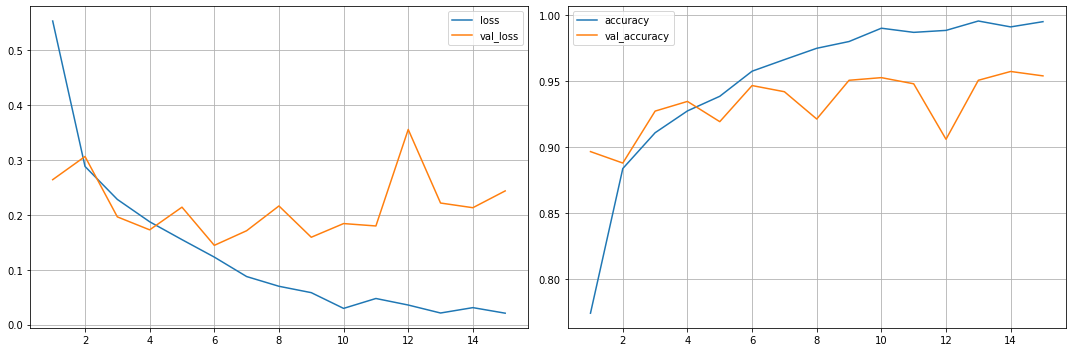

72/72 [==============================] - 30s 419ms/step - loss: 0.0208 - accuracy: 0.9950 - val_loss: 0.2438 - val_accuracy: 0.9540


In [ ]:
history = model.fit(
            train_generator,
            epochs=15,
            validation_data=test_generator,
            verbose=1,
            callbacks=callbacks_list

            )

In [ ]:
model.save("/content/drive/MyDrive/MlTask/model.h5")

In [1]:
from google.colab import files

In [ ]:
files.upload()

In [3]:
from keras.models import load_model

model = load_model("/content/drive/MyDrive/MlTask/model.h5")

Predicting test images

In [16]:
from PIL import Image
from google.colab.patches import cv2_imshow
import cv2
import numpy as np

def predict_mask(path):
  img = cv2.imread(path)
  cv2_imshow(img)
  img = cv2.resize(img, (150,150), interpolation = cv2.INTER_AREA)
  img = np.array(img)
  prediction = model.predict(img[None,:,:], verbose=0)
  if prediction[0][0] == 0:
    return "=>Mask Found"
  else:
    return "=>Mask Not Found"


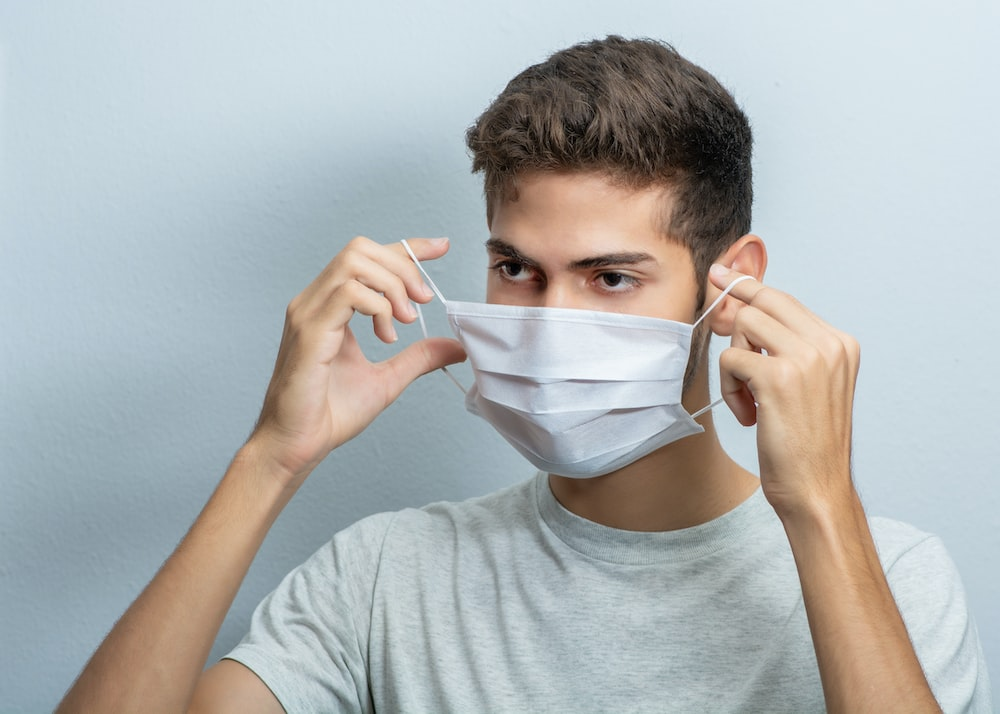

=>Mask Found


In [18]:
print(predict_mask("/content/mask.jfif"))